# Workflow Notebook
This notebook is intended to present models which are loaded from other files as well as the results they allow us to reach. It goes through the following steps:
* Defining Global Variables
* Loading Word Embeddings
* Loading Data
* Preprocessing Data
    * Correcting Spelling Mistakes
    * Spliting Training and Testing Data
    * Tokenizing Data
    * Building and Refining Embeddings Array
* Model definition
* Model training
* Model testing and evaluation

In [1]:
import csv
import gensim
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from gensim.models import Word2Vec
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import sequence, text
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Define Global Variables

In [60]:
RANDOM_SEED = 42
NB_CATEGORIES = 51

PADDING = 100
PRE_TRAINED_DIM = 300
REDUCED_DIM = 100

TRAINABLE = True # Training the embedding can lead to overfitting

dataDirPath = './challenge_data'
embeddingsDirPath = './../word_embeddings/'
xPath = os.path.join(dataDirPath, 'input_train.csv')
yPath = os.path.join(dataDirPath, 'output_train.csv')
xTestPath = os.path.join(dataDirPath, 'input_test.csv')
# embeddingPath = os.path.join(embeddingsDirPath, 'wiki.fr.vec')
embeddingPath = os.path.join(embeddingsDirPath, 'retrained_fr.vec')

## Loading Word Embeddings
Load from fasttext or EMEA.

In [3]:
pretrainedEmbeddings = gensim.models.KeyedVectors.\
    load_word2vec_format(embeddingPath, binary=False)

## Loading Data

In [61]:
x = pd.read_csv(xPath, delimiter=';', usecols=[1]).values.ravel()
xTest = pd.read_csv(xTestPath, delimiter=';', usecols=[1]).values.ravel()
y = pd.read_csv(yPath, delimiter=';', usecols=[1]).values.ravel()

## Preprocessing Data

### Correcting Spelling Mistakes

In [62]:
correctionsDict = {}
correctionsPath = os.path.join(dataDirPath, 'corrections.csv')

with open(correctionsPath, 'r') as f:
    for key, val in csv.reader(f):
        correctionsDict[key] = val

def spellingCorrection(sentence, correctionsDict={}):
    correctedSentence = []

    for word in sentence.split():
        word = correctionsDict[word] if word in correctionsDict.keys() else word
        correctedSentence.append(word)

    return ' '.join(correctedSentence)

for i, s in enumerate(x):
    x[i] = spellingCorrection(s, correctionsDict)

for i, s in enumerate(xTest):
    xTest[i] = spellingCorrection(s, correctionsDict)

### Tokenizing Data

In [63]:
tokenizer = text.Tokenizer(
    num_words=1e5,
    filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
    split=" "
)

tokenizer.fit_on_texts(np.concatenate((x, xTest)))
vocabulary = tokenizer.word_index.keys()

In [64]:
print('Vocabulary size: ', len(vocabulary))

Vocabulary size:  10175


### Downsampling Categories

In [65]:
def downsample(x, y, threshold=None, show=False):
    nb_categories = len(set(y))
    if threshold is None:
        countCategories = [0] * nb_categories
        for point in y:
            countCategories[point] += 1
        indexedCountCategories = list(zip(list(range(nb_categories)), countCategories))
        selectedCategories = list(filter(lambda x: x[1] > 100, indexedCountCategories))
        #threshold = np.percentile([cat[1] for cat in selectedCategories], 75)
        threshold = np.mean([cat[1] for cat in selectedCategories])
    print('Thresholding each category to {} datapoints.'.format(threshold))
    X = []
    Y = []
    count_categories = np.zeros(nb_categories)
    for xx, yy in zip(x, y):
        if count_categories[yy] <= threshold:
            X.append(xx)
            Y.append(yy)
            count_categories[yy]+=1
    X = np.array(X)
    Y = np.array(Y)
    if show == True:
        plt.figure(figsize=(15, 5))
        plt.hist(Y, bins=nb_categories, label='train labels', density=False, alpha=1)
        plt.axis
        plt.legend()
        plt.show()
    return X, Y

Thresholding each category to 2000 datapoints.


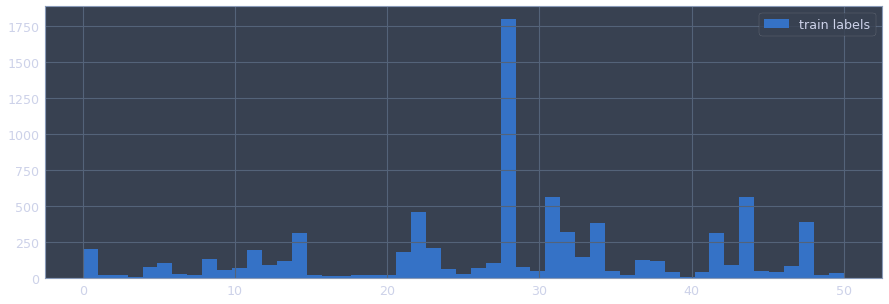

In [66]:
x, y = downsample(x, y, threshold=2000, show=True)

### Parsing Inputs And Outputs

In [67]:
x = tokenizer.texts_to_sequences(x)
x = sequence.pad_sequences(x, PADDING)
xTest = tokenizer.texts_to_sequences(xTest)
xTest = sequence.pad_sequences(xTest, PADDING)

y = to_categorical(y, num_classes=NB_CATEGORIES)

### Spliting Training And Validation Data

In [68]:
xTrain, xValid, yTrain, yValid = train_test_split(x, y, test_size=.2,
                                                  random_state=RANDOM_SEED)

### Building And Refining Embedding Array

#### Loading Medic Names

In [69]:
MEDICAMENTS = []

with open(os.path.join(dataDirPath, 'medicList.txt')) as f:
    for line in f:
        MEDICAMENTS.append(line.lower().rstrip())

print('Liste de médicaments regroupant les libéllés ATC et les'
      'dénominations de spécialité, de taille: {}'.format(len(MEDICAMENTS)))
print('Sample of medicament names: ', MEDICAMENTS[:10])

Liste de médicaments regroupant les libéllés ATC et lesdénominations de spécialité, de taille: 8390
Sample of medicament names:  ['a 313 200  pour cent', 'a 313 50 000 u.i', 'abacavir', 'abacavir/lamivudine', 'abacavir/lamivudine pharma', 'abacavir/lamivudine pharos', 'abamipharm', 'abboticine', 'abelcet', 'abstral']


#### Building Embeddings

In [70]:
from unidecode import unidecode

In [71]:
# We use an embedding size of len(x_vocab) + 1 because the 0 is used for the padding
embeddings = np.zeros((len(vocabulary) + 1 , PRE_TRAINED_DIM))
not_in_pretrained = []
detected_medic = []

for word, idx in tokenizer.word_index.items():
    if word not in pretrainedEmbeddings.vocab:
        unaccented = unidecode(word)
        if word in MEDICAMENTS:
            vec = pretrainedEmbeddings['médicament']
            detected_medic.append(word)
        else:
            vec = np.zeros(PRE_TRAINED_DIM)
            not_in_pretrained.append(word)
    else:
        vec = pretrainedEmbeddings[word]

    # word_to_index is 1-based! the 0-th row, used for padding, stays at zero
    embeddings[idx,] = vec

In [72]:
print('---------- Embedding Created ----------')
print('Number of words in corpus that do not appear in '
      'pretrained Fasttext: ', len(not_in_pretrained))

---------- Embedding Created ----------
Number of words in corpus that do not appear in pretrained Fasttext:  1468


#### Reducing Embeddings Dimension

In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=REDUCED_DIM)
reducedEmbeddings = pca.fit_transform(embeddings)

## Model Definition

### Generic Methods

In [84]:
class CustomModel():
    '''Generic workflow class.'''

    def __init__(self, **kwargs):
        self.verbose = kwargs.get('verbose', False)

        self.nbCategories = kwargs['nbCategories']
        self.paddingLength = PADDING
        self.trainable = kwargs.get('trainable', False)

    def train(self, x, y, epochs= 10, batch_size=32, validation_data=None, callback=False):
        if callback == True:
            filepath= '../models_checkpoints/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
            checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                                         verbose=1, save_best_only=True, mode='max')
            callbacks_list = [checkpoint]

            return self.model.fit(x, y, shuffle='batch', epochs=epochs,
                                  verbose=1 if self.verbose else 0,
                                  batch_size=batch_size, validation_data=validation_data,
                                  callbacks=callbacks_list)
        else:
            return self.model.fit(x, y, shuffle='batch', epochs=epochs,
                                  verbose=1 if self.verbose else 0,
                                  batch_size=batch_size, validation_data=validation_data)

    def evaluate(self, x, y):
        return self.model.evaluate(x, y)

    def predict(self, x):
        return self.model.predict(x)

### Mathematical Model
Here, we implement several models (CNN, RNN, etc) with different shapes.

In [85]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import Input, Conv1D, Dense, Dropout, GlobalMaxPooling1D, MaxPooling1D

class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def buildCNN1D(self, embedding, drop_rates=[.3, .3], nb_filters=128,
                   filter_size=4, padding=PADDING):
        self.embedding = embedding

        my_input = keras.Input(shape=(self.paddingLength,), name= 'input')

        embedding = (Embedding(input_dim=self.embedding.shape[0],
                               output_dim=self.embedding.shape[1],
                               weights=[self.embedding],
                               input_length=self.paddingLength,
                               trainable=self.trainable,
                               name='embedding'))(my_input)
        embedding_dropped = Dropout(drop_rates[0], name='drop0')(embedding)

        conv1 = Conv1D(nb_filters, filter_size,
                       activation='relu', name='conv1')(embedding_dropped)
    
        pooled1 = MaxPooling1D(pool_size=3, strides=None, name='pool1')

        conv2 = Conv1D(nb_filters, filter_size,
                       activation='relu', name='conv2')(conv1)

        pooled2 = GlobalMaxPooling1D(name='pool2')(conv2)
    
        dropped1 = Dropout(drop_rates[1], name='drop1')(pooled2)
        
        prob = Dense(self.nbCategories, activation='softmax', name='softmax')(dropped1)
        
        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

In [86]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import (Input, Conv2D, Dense, Dropout,
                          MaxPooling2D, Flatten, Concatenate, Reshape)


class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def buildCNN2D(self, embedding, drop_rates=[.3,.3] , nb_filters=128, filter_size=[3,4,5],
                   padding=PADDING):
        self.embedding = embedding

        my_input = Input(shape=(self.paddingLength, ), name= 'input')

        embedding = Embedding(input_dim=self.embedding.shape[0],
                               output_dim=self.embedding.shape[1],
                               weights=[self.embedding],
                               input_length=self.paddingLength,
                               trainable=self.trainable,
                               name='embedding')(my_input)
        embedding = Reshape((padding, self.embedding.shape[1], 1))(embedding)
        embedding_dropped = Dropout(drop_rates[0], name='drop0')(embedding)
        
        # one concatenates 3 filter sizes
        conv0 = Conv2D(nb_filters, (filter_size[0], self.embedding.shape[1]),
                       activation='relu', name='conv0', padding='valid')(embedding_dropped)
        pooled0 = MaxPooling2D(pool_size=(padding - filter_size[0] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool0')(conv0)
        
        conv1 = Conv2D(nb_filters, (filter_size[1], self.embedding.shape[1]),
                       activation='relu', name='conv1', padding='valid')(embedding_dropped)
        pooled1 = MaxPooling2D(pool_size = (padding - filter_size[1] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool1')(conv1)
        
        conv2 = Conv2D(nb_filters, (filter_size[2], self.embedding.shape[1]),
                       activation='relu', name='conv2', padding='valid')(embedding_dropped)
        pooled2 = MaxPooling2D(pool_size = (padding - filter_size[2] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool2')(conv2)
        
        concatenated = Concatenate(axis=1)([pooled0, pooled1, pooled2])
        flattened = keras.layers.Flatten()(concatenated)
        dropped1 = Dropout(drop_rates[1], name='drop1')(flattened)  
        prob = Dense(self.nbCategories, activation='softmax', name='dense2')(dropped1)

        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

## Model training

In [87]:
def plotHistory(history):
    plt.figure(figsize=(15,8))

    plt.subplot(121)
    plt.plot(history['acc'], label='Accuracy')
    plt.plot(history['val_acc'], label='Validaction Accuracy')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(122)
    plt.plot(history['loss'], label='Loss')
    plt.plot(history['val_loss'], label='Validaction Loss')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.show()

In [91]:
DROP_RATES = [.4, .4]
NB_FILTERS = 256
FILTER_SIZE = 3

trainingHistory = {}

model = CustomModel(verbose=True, nbCategories=NB_CATEGORIES, trainable=TRAINABLE)
# model.buildCNN1D(reducedEmbeddings, drop_rates=DROP_RATES, nb_filters=NB_FILTERS,
#                  filter_size=FILTER_SIZE)
model.buildCNN2D(reducedEmbeddings, drop_rates=DROP_RATES, nb_filters=NB_FILTERS)
model.model.summary()

print('Total number of model parameters:', model.model.count_params())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 100)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     1017600     input[0][0]                      
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 100, 100, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
drop0 (Dropout)                 (None, 100, 100, 1)  0           reshape_6[0][0]                  
__________________________________________________________________________________________________
conv0 (Con

In [95]:
BATCH_SIZE = 256
EPOCHS = 5

trainingPartialHistory = model.train(xTrain, yTrain, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                     validation_data=(xValid, yValid), callback=True)

for key in trainingPartialHistory.history:
    if key in trainingHistory:
        trainingHistory[key] += trainingPartialHistory.history[key]
    else:
        trainingHistory[key] = trainingPartialHistory.history[key]

Train on 6422 samples, validate on 1606 samples
Epoch 1/5
6422/6422 [==============================] - 16s 2ms/step - loss: 0.2803 - acc: 0.9215 - val_loss: 1.2052 - val_acc: 0.7011

Epoch 00001: val_acc improved from -inf to 0.70112, saving model to ../models_checkpoints/weights-improvement-01-0.70.hdf5
Epoch 2/5
6422/6422 [==============================] - 16s 3ms/step - loss: 0.2735 - acc: 0.9242 - val_loss: 1.2096 - val_acc: 0.7049

Epoch 00002: val_acc improved from 0.70112 to 0.70486, saving model to ../models_checkpoints/weights-improvement-02-0.70.hdf5
Epoch 3/5
6422/6422 [==============================] - 16s 3ms/step - loss: 0.2600 - acc: 0.9279 - val_loss: 1.2028 - val_acc: 0.7005

Epoch 00003: val_acc did not improve
Epoch 4/5
6422/6422 [==============================] - 16s 3ms/step - loss: 0.2598 - acc: 0.9263 - val_loss: 1.2111 - val_acc: 0.7024

Epoch 00004: val_acc did not improve
Epoch 5/5
6422/6422 [==============================] - 17s 3ms/step - loss: 0.2662 - acc:

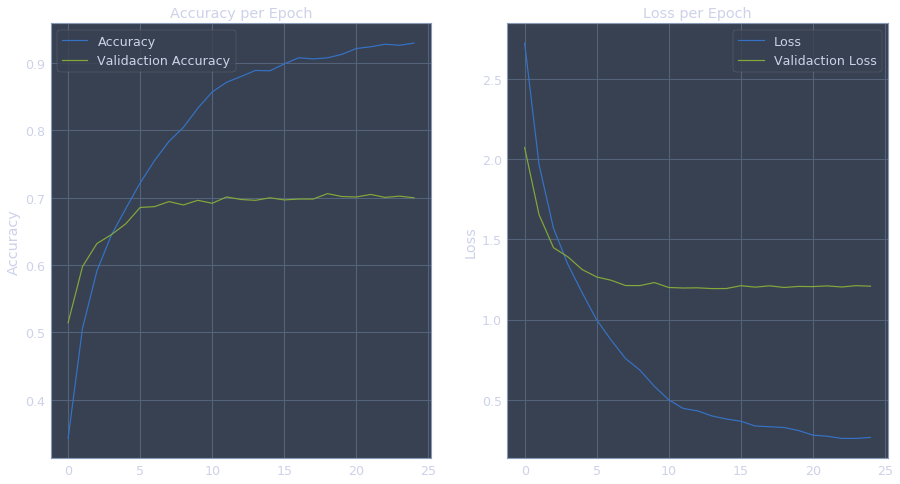

In [96]:
plotHistory(trainingHistory)

## Grid Search Cross Validation

### Embedding Size
(Optimized for `DROPOUT_RATE=.4`)

In [ ]:
embeddingCV = range(50, 301, 50)
BATCH_SIZE = 32
DROP_RATES = [.4, .4]
NB_FILTERS = 256
EPOCHS = 10
saveFileName = 'accuracies_embeddings_50_301_50.txt'

accuracies = []
for dim in tqdm(embeddingCV):
    pcaCV = PCA(n_components=dim)
    reducedEmbeddingsCV = pcaCV.fit_transform(embeddings)

    model = CustomModel(verbose=False, nbCategories=NB_CATEGORIES, trainable=TRAINABLE)
    model.buildCNN2D(reducedEmbeddingsCV, drop_rates=DROP_RATES, nb_filters=NB_FILTERS)

    history = model.train(xTrain, yTrain, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          validation_data=(xValid, yValid))
    accuracies.append(history.history['acc'])

 50%|█████     | 3/6 [08:33<08:33, 171.16s/it]

### Saved Results

In [ ]:
with open('./../cross_validation/{}'.format(saveFileName), 'w+') as f:
    writer = csv.writer(f, delimiter=';')
    for line in accuracies:
        writer.writerow(line)

In [ ]:
plt.figure(figsize=(15,8))
embeddingCVList = list(embeddingCV)

for i, accs in accuracies:
    plt.plot(embeddingCVList, accs, label=embeddingCVList[i])

plt.ylabel('Accuracy')
plt.xlabel('Embedding Size')
plt.legend()
plt.title('Effect of Embedding Size on Accuracy')

plt.show()

## Model Evaluation

### Predict

In [97]:
loss = model.evaluate(xValid, yValid)

prediction = model.predict(xValid)
predictionCategories = np.argmax(prediction, axis=1)
yValidCategories = np.argmax(yValid, axis=1)
accuracy = 100 * sum([predictionCategories[i] == yValidCategories[i]
                      for i in range(len(yValidCategories))]) / len(yValidCategories)

print('Accuracy: {:.2f} %\nLoss: {}'.format(accuracy, str(loss)))

1606/1606 [==============================] - 1s 469us/step
Accuracy: 69.99 %
Loss: [1.20771831815893, 0.6998754669987547]


### Plot Accuracy Per Category

In [98]:
import collections

In [99]:
yPosition = np.arange(2*NB_CATEGORIES)

c = collections.Counter(yValidCategories)
od = collections.OrderedDict(sorted(c.items(), key=lambda x: x[0]))
cp = collections.Counter(predictionCategories)
odp = collections.OrderedDict(sorted(cp.items(), key=lambda x: x[0]))

correctResults = predictionCategories[predictionCategories == yValidCategories]
cc = collections.Counter(correctResults)
odc = collections.OrderedDict(sorted(cc.items(), key=lambda x: x[0]))

In [100]:
pod = np.zeros(2*NB_CATEGORIES)
for key in od:
    pod[2*key] = od[key]

podp = np.zeros(2*NB_CATEGORIES)
for key in odp:
    podp[2*key+1] = odp[key]

podc = np.zeros(2*NB_CATEGORIES)
for key in odc:
    podc[2*key+1] = odc[key]

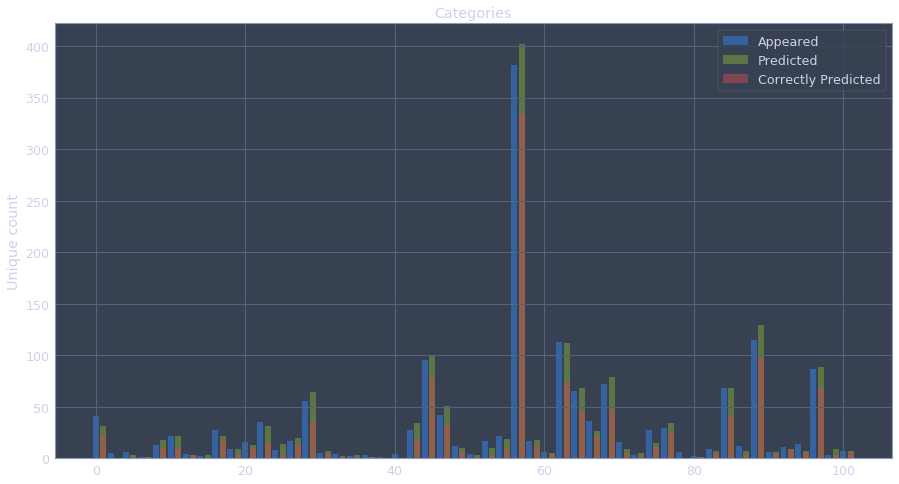

In [101]:
plt.figure(figsize=(15,8))
#plt.yscale('log')

plt.bar(yPosition, pod, alpha=0.7, label='Appeared')
plt.bar(yPosition, podp, alpha=0.5, label='Predicted')
plt.bar(yPosition, podc, alpha=0.5, label='Correctly Predicted')

plt.ylabel('Unique count')
plt.title('Categories')
plt.legend()
 
plt.show()

## Export Coefficients
Predict results for the test data and output results in a `output_test.csv`.

In [58]:
exportY = model.predict(xTest)
exportY = np.argmax(exportY, axis=1)

In [59]:
with open(os.path.join(dataDirPath, 'output_test.csv'), 'w+') as f:
    f.write('ID;intention\n')

    for i, p in enumerate(exportY):
        f.write('{};{}\n'.format(str(i), str(p)))

In [60]:
exportY

array([34, 32, 28, ..., 28, 14, 34])